In [2]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import data_gen2

from IPython.display import display, Markdown, Latex, Math

%matplotlib notebook
#plt.ion()

%load_ext tikzmagic

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # I don't have a GPU to test this

In [3]:
# Set up the ReLULayer Pytorch module
# Apply affine transformation then rectified linear unit
class ReLULayer(nn.Module):
    # Set up a ReLU layer for ease of use
    def __init__(self, input_dim, output_dim):
        super(ReLULayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim) # Just one affine transformation

    def forward(self, x):
        return F.relu(self.linear(x)) # Apply the affine transformation and then the ReLU

In [4]:
# Set up the NeuralNetwork class
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_structure, learning_rate=0.001):
        super(NeuralNetwork, self).__init__()
        self.hidden_structure = hidden_structure

        layers = []
        layers.append(ReLULayer(input_dim, hidden_structure[0])) # Setup initial hidden layer

        for i in range(1, len(hidden_structure)):
            layers.append(ReLULayer(hidden_structure[i-1], hidden_structure[i])) # Setup hidden layers

        layers.append(nn.Linear(hidden_structure[-1], output_dim)) # Setup output layer (linear)

        self.layers = nn.ModuleList(layers)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        self.num_params = sum([np.prod(p.size()) for p in model_parameters])

    def forward(self, x):
        out = x

        for layer in self.layers:
            out = layer(out) # Apply hidden layers

        return out

    def train(self, X_train, y_train, loss_function):
        pred = self(X_train) # Predict from our inputs
        loss = loss_function(pred, y_train) # Calculate the loss
        # Backpropgate
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss

In [5]:
# Set up the data generators
def circles(n, r1=0.5):
    x = np.zeros((n, 2))
    y = np.zeros((n, 2))
    i = 0
    
    r1sqr = r1**2
    r2sqr = 2*r1sqr
    r3sqr = 3*r1sqr

    while i < n//2:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if np.sum(np.square(sample)) < r1sqr:
            x[i, :] = sample
            y[i, :] = np.array([0, 1])
            i += 1

    while i < n:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if r2sqr < np.sum(np.square(sample)) < r3sqr:
            x[i, :] = sample
            y[i, :] = np.array([1, 0])
            i += 1

    return x, y

def circlesAlt(n, r1=0.5):
    x = np.zeros((n, 2))
    y = np.zeros((n, 1))
    i = 0
    
    r1sqr = r1**2
    r2sqr = 2*r1sqr
    r3sqr = 3*r1sqr

    while i < n//2:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if np.sum(np.square(sample)) < r1sqr:
            x[i, :] = sample
            y[i, :] = 1
            i += 1

    while i < n:
        sample = 2*np.random.uniform(size=(1,2)) - 1
        if r2sqr < np.sum(np.square(sample)) < r3sqr:
            x[i, :] = sample
            y[i, :] = -1
            i += 1

    return x, y

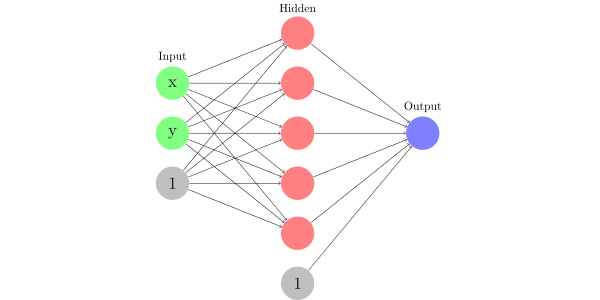

In [3]:
%%tikz --scale=0.75 --size=600,300 --format=svg

\node [circle,fill=green!50,minimum size=1cm] (input-1) at (0,2) {\Large x};
\node [circle,fill=green!50,minimum size=1cm] (input-2) at (0,0) {\Large y};
\node [circle,fill=gray!50,minimum size=1cm] (input-bias) at (0, -2) {\Large 1};

\node [above] at (input-1.north) {Input};

\node [circle,fill=red!50,minimum size=1cm ] (hidden-1) at (5,4) {};
\node [circle,fill=red!50,minimum size=1cm ] (hidden-2) at (5,2) {};
\node [circle,fill=red!50,minimum size=1cm ] (hidden-3) at (5,0) {};
\node [circle,fill=red!50,minimum size=1cm ] (hidden-4) at (5,-2) {};
\node [circle,fill=red!50,minimum size=1cm ] (hidden-5) at (5,-4) {};
\node [circle,fill=gray!50,minimum size=1cm] (hidden-bias) at (5, -6) {\Large 1};
\node [above] at (hidden-1.north) {Hidden};

\node [circle,fill=blue!50,minimum size=1cm ] (output-1) at (10,0) {};
\node [above] at (output-1.north) {Output};

\draw [->] (input-1) -- (hidden-1);
\draw [->] (input-1) -- (hidden-2);
\draw [->] (input-1) -- (hidden-3);
\draw [->] (input-1) -- (hidden-4);
\draw [->] (input-1) -- (hidden-5);

\draw [->] (input-2) -- (hidden-1);
\draw [->] (input-2) -- (hidden-2);
\draw [->] (input-2) -- (hidden-3);
\draw [->] (input-2) -- (hidden-4);
\draw [->] (input-2) -- (hidden-5);

\draw [->] (input-bias) -- (hidden-1);
\draw [->] (input-bias) -- (hidden-2);
\draw [->] (input-bias) -- (hidden-3);
\draw [->] (input-bias) -- (hidden-4);
\draw [->] (input-bias) -- (hidden-5);

\draw [->] (hidden-1) -- (output-1);
\draw [->] (hidden-2) -- (output-1);
\draw [->] (hidden-3) -- (output-1);
\draw [->] (hidden-4) -- (output-1);
\draw [->] (hidden-5) -- (output-1);
\draw [->] (hidden-bias) -- (output-1);

* Unnecessarily large
* Trains to good optima more frequently than just 3 hidden units
* Hope to take advantage of redundancy during translation

<IPython.core.display.Javascript object>


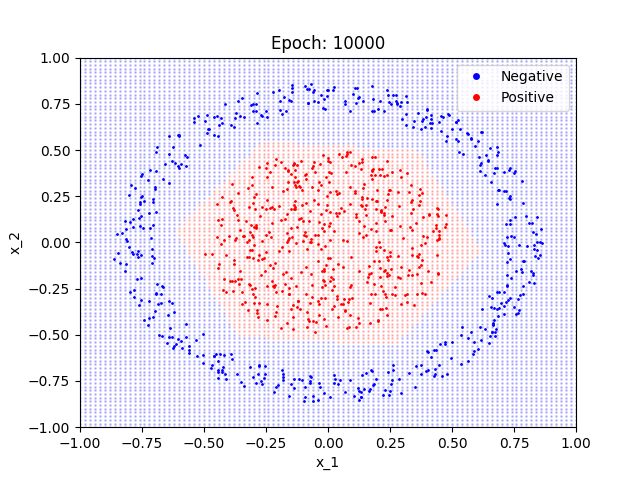

In [7]:
# Run the network and display steps

# Data info
num_inputs = 2
num_outputs = 1
num_samples = 100
hidden_structure = [5]
data_func = lambda n: circlesAlt(n)

# Hyper-parameters 
num_epochs = 10000
learning_rate = 0.001

# Setup for the network
model = NeuralNetwork(num_inputs, num_outputs, hidden_structure, learning_rate=learning_rate).to(device)

# Count the number of trainable parameters and display it
#print('Number of parameters:', model.num_params)

# Set up optimization technique
#loss_function = nn.BCEWithLogitsLoss() # Binary cross entropy
#loss_function = nn.CrossEntropyLoss() # Multi-class
#loss_function = nn.L1Loss() # L1 norm
loss_function = nn.MSELoss() # L2 norm divided by num samples 

# Setup for plotting progress
fig, ax = plt.subplots()
fig.show()
fig.canvas.draw()

thing = 101
x = np.linspace(-1, 1, thing)
y = np.linspace(-1, 1, thing)

X, Y = np.meshgrid(x, y)

x = np.reshape(X, thing**2)
y = np.reshape(Y, thing**2)

X_test = torch.from_numpy(np.vstack((x, y)).T).float()

for epoch in range(num_epochs):
    # Get the training data in a useful data structure
    X_train, y_train = data_func(num_samples)
    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    
    loss = model.train(X_train, y_train, loss_function)
    
    if (epoch+1) %1000 == 0  or epoch == 0:
        # Display the running accuracy
        #print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, loss.item()))
        
        pred = model(X_test).detach().numpy()
        
        # Plot the classification map
        ax.clear()
        
        data_gen2.plotClassifierDataAlt(X_test, pred, plot=(fig, ax), alpha=0.2)
        X_train, y_train = data_func(1000)
        data_gen2.plotClassifierDataAlt(X_train, y_train, plot=(fig, ax))
        ax.set_title('Epoch: ' + str(epoch+1))
        ax.set_xlabel('x_1')
        ax.set_ylabel('x_2')
        
        
        legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', label='Negative'),
                           matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', label='Positive')]
        ax.legend(handles=legend_elements)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        

In [31]:
# Create LaTeX output from numpy arrays
def createLatex(A1, b1, A2, b2):
    
    A2Display = Math('A^{{(2)}} = \\begin{{bmatrix}} {A2[0]} & {A2[1]} & {A2[2]} & {A2[3]} & {A2[4]} \\end{{bmatrix}}'.format(A2=A2.tolist()[0]))
    b2Display = Math('b^{{(2)}} = {b2[0]}'.format(b2=b2.tolist()))
    A1Display = Math('''A^{{(1)}} = \\begin{{bmatrix}} {A1[0][0]} & {A1[0][1]} \\\\ 
                       {A1[1][0]} & {A1[1][1]} \\\\
                       {A1[2][0]} & {A1[2][1]} \\\\
                       {A1[3][0]} & {A1[3][1]} \\\\
                       {A1[4][0]} & {A1[4][1]} \\\\\\end{{bmatrix}}'''.format(A1=A1.tolist()))
    b1Display = Math('b^{{(1)}} = \\begin{{bmatrix}} {b1[0]} \\\\ {b1[1]} \\\\ {b1[2]} \\\\ {b1[3]} \\\\ {b1[4]} \\end{{bmatrix}}'.format(b1=b1.tolist()))
    
    
    display(A2Display)
    display(b2Display)
    display(A1Display)
    display(b1Display)

In [100]:
# Get model parameters
params = []
secondLayer = []

for param in model.parameters():
    params.append(param.detach().numpy())

#print(params)
A1 = params[0]
b1 = params[1]
A2 = params[2]
b2 = params[3]
system = Math(r'f(x) = A^{(2)} \max \{ A^{(1)} x + b^{(1)}, 0 \} + b^{(2)}')
display(system)
createLatex(A1, b1, A2, b2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [99]:
# Save model parameters
np.savez('saveFile', A1=A1, b1=b1, A2=A2, b2=b2)
#temp = np.load('saveFile.npz')

We now want the elements of $A^{(1)}$ and $A^{(2)}$ to be integers, so we first scale the system:
\begin{align*}
f(x) &= A^{(2)} \max \left\{ A^{(1)} x + b^{(1)}, 0 \right\} + b^{(2)} \\
     &= A^{(2)} \max \left\{ \frac{10^n A^{(1)}}{10^n} x + b^{(1)}, 0\right\} + b^{(2)} \\
     &= A^{(2)} \frac{\max \left\{ 10^n A^{(1)} x + 10^n b^{(1)}, 0\right\}}{10^n} + b^{(2)} \\
     &= 10^n A^{(2)} \frac{\max \left\{ 10^n A^{(1)} x + 10^n b^{(1)}, 0\right\}}{10^{2n}} + b^{(2)} \\
     &= \frac{10^n A^{(2)} \max \left\{ 10^n A^{(1)} x + 10^n b^{(1)}, 0\right\} + 10^{2n} b^{(2)}}{10^{2n}}
\end{align*}

Note: On this problem, we only care about positive versus negative, so we can ignore the scaling term, but in general it would be necessary to maintain throughout.

In [55]:
# Set n = 1 and do this
n = 1
A1scaled = (10**n)*A1
A2scaled = (10**n)*A2
b1scaled = (10**n)*b1
b2scaled = (10**(2*n))*b2
createLatex(A1scaled, b1scaled, A2scaled, b2scaled)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We want integer values in the $A$ matrices to have polynomials rather than signomials, so we drop the decimal portions

In [56]:
# Round the system 
A1rounded = np.round(A1scaled).astype(int)
A2rounded = np.round(A2scaled).astype(int)
b1rounded = np.round(b1scaled).astype(int)
b2rounded = np.round(b2scaled).astype(int)
createLatex(A1rounded, b1rounded, A2rounded, b2rounded)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We now want to test this system on the original dataset to ensure we have lost minimal accuracy.

Note: I tested this even with $n=0$ (just rounding) and it still had reasonable accuracy.

<IPython.core.display.Javascript object>


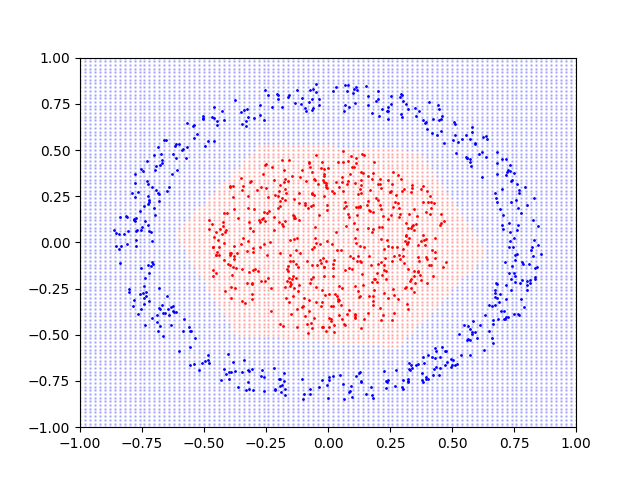

In [57]:
# Test and plot
res = np.matmul(A1rounded, X_test.numpy().T) + b1rounded[:,np.newaxis]
res[res < 0] = 0
res = np.matmul(A2rounded, res) + b2rounded

fig, ax = plt.subplots()
data_gen2.plotClassifierDataAlt(X_test, res[0], plot=(fig, ax), alpha=0.2)
X_train, y_train = data_func(1000)
data_gen2.plotClassifierDataAlt(X_train, y_train, plot=(fig, ax))

Since we want polynomials, we will need non-negative degrees.  To do this, we first consider
\begin{equation*}
\max \left\{ A^{(1)} x + b^{(1)}, 0 \right\}.
\end{equation*}

Breaking the $A^{(1)}$ into $A^{(1)}_+$ and $A^{(1)}_-$ both of which have positive or zero values such that
\begin{equation*}
A^{(1)} = A^{(1)}_+ - A^{(1)}_-
\end{equation*}

yields

\begin{align*}
\max \left\{ A^{(1)} x + b^{(1)}, 0 \right\} &= \max \left\{ \left(A^{(1)}_+ - A^{(1)}_-\right) x + b^{(1)}, 0 \right\} \\
&= \max \left\{ A^{(1)}_+ x - A^{(1)}_- x + b^{(1)}, 0 \right\} \\
&= \max \left\{ A^{(1)}_+ x + b^{(1)}, A^{(1)}_- x \right\} - A^{(1)}_- x\\
\end{align*}

The equations to translate this to tropical algebra are

\begin{align*}
\nu^{(i+1)} &= F^{(i+1)} - G^{(i+1)} = F^{(i+1)} \oslash G^{(i+1)}, \\
F^{(i+1)}_j &= H_j^{(i+1)} \oplus G^{(i+1)}_j, \\
G^{(i+1)}_j &= \left[ \bigodot_{k=1}^{n_i} \left( F_k^{(i)}\right)^{\displaystyle \odot a^{(i+1)}_{jk,-}} \right] \odot \left[ \bigodot_{k=1}^{n_i} \left( G_k^{(i)}\right)^{\displaystyle \odot a^{(i+1)}_{jk,+}} \right] \\
H^{(i+1)}_j &= \left[ \bigodot_{k=1}^{n_i} \left( F_k^{(i)}\right)^{\displaystyle \odot a^{(i+1)}_{jk,+}} \right] \odot \left[ \bigodot_{k=1}^{n_i} \left( G_k^{(i)}\right)^{\displaystyle \odot a^{(i+1)}_{jk,-}} \right] \odot b_j^{(i+1)}
\end{align*}

but these are not necessarily useful for the first layer (and are really just variants of the tropical algebraic formulation for matrix-vector multiplication).

In our case (noting that the subscripting here is different),

\begin{align*}
F^{(1)}_j &= \max\{H^{(1)}_j, G^{(1)}_j\} \\
G^{(1)}_j &= A^{(1)}_{j,-} x \\
H^{(1)}_j &= A^{(1)}_{j,+} x + b^{(1)}_j
\end{align*}

which is equivalent to 

\begin{align*}
F^{(1)}_j &= \max\{H^{(1)}_j, G^{(1)}_j\} \\
G^{(1)}_j &= \sum_{k=1}^5 a^{(1)}_{jk,-} x_k \\
H^{(1)}_j &= \sum_{k=1}^5 a^{(1)}_{jk,+} x_k + b^{(1)}_j
\end{align*}

or in tropical form,

\begin{align*}
F^{(1)}_j &= H^{(1)}_j \oplus G^{(1)}_j\ \\
G^{(1)}_j &= \bigodot_{k=1}^5 x_k^{\displaystyle \odot a^{(1)}_{jk,-}} \\
H^{(1)}_j &= \bigodot_{k=1}^5 x_k^{\displaystyle \odot a^{(1)}_{jk,+}} \odot b^{(1)}_j
\end{align*}

In [58]:
# Our system is
createLatex(A1rounded, b1rounded, A2rounded, b2rounded)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

So we have

\begin{align*}
G^{(1)} &= \begin{bmatrix} x_1^{\odot 1} \odot x_2^{\odot 16} \\
                          x_1^{\odot 2} \odot x_2^{\odot 25} \\
                                              x_2^{\odot 14} \\ 
                          x_1^{\odot 1} \odot x_2^{\odot 13} \\
                          x_1^{\odot 20} \odot x_2^{\odot 10}
\end{bmatrix} \\
H^{(1)} &= \begin{bmatrix} 12 \\ 0 \\ x_1^{\odot 19} \\ 10 \\ 0 \end{bmatrix} \\
F^{(1)} &= \begin{bmatrix} 12 \oplus x_1^{\odot 1} \odot x_2^{\odot 16} \\
                           0 \oplus x_1^{\odot 2} \odot x_2^{\odot 25} \\
                           x_1^{\odot 19} \oplus x_2^{\odot 14} \\
                           10 \oplus x_1^{\odot 1} \odot x_2^{\odot 13} \\
                           0 \oplus x_1^{\odot 20} \odot x_2^{\odot 10}
\end{bmatrix} \\
F^{(1)} \oslash G^{(1)} &= \begin{bmatrix}
(12 \oplus x_1^{\odot 1} \odot x_2^{\odot 16}) \oslash (x_1^{\odot 1} \odot x_2^{\odot 16}) \\
(0 \oplus x_1^{\odot 2} \odot x_2^{\odot 25}) \oslash (x_1^{\odot 2} \odot x_2^{\odot 25}) \\
(x_1^{\odot 19} \oplus x_2^{\odot 14}) \oslash (x_2^{\odot 14}) \\
(10 \oplus x_1^{\odot 1} \odot x_2^{\odot 13}) \oslash (x_1^{\odot 1} \odot x_2^{\odot 13}) \\
(0 \oplus x_1^{\odot 20} \odot x_2^{\odot 10}) \oslash (x_1^{\odot 20} \odot x_2^{\odot 10})
\end{bmatrix}
\end{align*}

For the next layer in general, we would have

$ \max \{ A^{(2)} (F-G) + b^{(2)}, 0 \} $

which we can change to (using the same positive/negative trick)

\begin{align*}
\max \{ A^{(2)} (F-G) + b^{(2)}, 0 \} &= \max \{ (A^{(2)}_+ - A^{(2)}_-) (F-G) + b^{(2)}, 0 \} \\
                                      &= \max \{ A^{(2)}_+ F + A^{(2)}_- G + b^{(2)} - (A^{(2)}_- F + A^{(2)}_+ G), 0 \} \\
                                      &= \max \{ A^{(2)}_+ F + A^{(2)}_- G + b^{(2)}, A^{(2)}_- F + A^{(2)}_+ G\} - (A^{(2)}_- F + A^{(2)}_+ G)
\end{align*}

which is the form of

\begin{align*}
F^{(i+1)}_j &= H_j^{(i+1)} \oplus G^{(i+1)}_j, \\
G^{(i+1)}_j &= \left[ \bigodot_{k=1}^{n_i} \left( F_k^{(i)}\right)^{\displaystyle \odot a^{(i+1)}_{jk,-}} \right] \odot \left[ \bigodot_{k=1}^{n_i} \left( G_k^{(i)}\right)^{\displaystyle \odot a^{(i+1)}_{jk,+}} \right] \\
H^{(i+1)}_j &= \left[ \bigodot_{k=1}^{n_i} \left( F_k^{(i)}\right)^{\displaystyle \odot a^{(i+1)}_{jk,+}} \right] \odot \left[ \bigodot_{k=1}^{n_i} \left( G_k^{(i)}\right)^{\displaystyle \odot a^{(i+1)}_{jk,-}} \right] \odot b_j^{(i+1)}
\end{align*}

In [78]:
# Our system is
createLatex(A1rounded, b1rounded, A2rounded, b2rounded)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In going to layer 2, it is useful to write

$F^{(1)} = \begin{bmatrix} 12 \oplus x_1^{\odot 1} \odot x_2^{\odot 16} \\
                           0 \oplus x_1^{\odot 2} \odot x_2^{\odot 25} \\
                           x_1^{\odot 19} \oplus x_2^{\odot 14} \\
                           10 \oplus x_1^{\odot 1} \odot x_2^{\odot 13} \\
                           0 \oplus x_1^{\odot 20} \odot x_2^{\odot 10}
\end{bmatrix} = \begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \\ y_5 \end{bmatrix} $

and

$G^{(1)} = \begin{bmatrix} x_1^{\odot 1} \odot x_2^{\odot 16} \\
                          x_1^{\odot 2} \odot x_2^{\odot 25} \\
                                              x_2^{\odot 14} \\ 
                          x_1^{\odot 1} \odot x_2^{\odot 13} \\
                          x_1^{\odot 20} \odot x_2^{\odot 10}
\end{bmatrix} = \begin{bmatrix} z_1 \\ z_2 \\ z_3 \\ z_4 \\ z_5 \end{bmatrix}. $

Then,

\begin{align*}
G^{(2)} &= y_2^{\odot 16} \odot y_3^{\odot 17} \odot y_5^{\odot 18} \odot z_1^{\odot 13} \odot z_4^{\odot 16} \\
H^{(2)} &= y_1^{\odot 13} \odot y_4^{\odot 16} \odot z_2^{\odot 16} \odot z_3^{\odot 17} \odot z_5^{\odot 18} \odot -99.
\end{align*}

Since our layer two does not have the maximum, we only have the 

$A^{(2)}_+ F + A^{(2)}_- G + b^{(2)} - (A^{(2)}_- F + A^{(2)}_+ G)$

portion and our final equation will be of the form

$ f(x) = H^{(2)} \oslash G^{(2)}. $

We now substitute in for $y$ and $z$.  This gives

\begin{align*}
G^{(2)} &= (0 \oplus x_1^{\odot 2} \odot x_2^{\odot 25})^{\odot 16} \odot (x_1^{\odot 19} \oplus x_2^{\odot 14})^{\odot 17} \odot (0 \oplus x_1^{\odot 20} \odot x_2^{\odot 10})^{\odot 18} \odot (x_1^{\odot 1} \odot x_2^{\odot 16})^{\odot 13} \odot (x_1^{\odot 1} \odot x_2^{\odot 13})^{\odot 16} \\
H^{(2)} &= (12 \oplus x_1^{\odot 1} \odot x_2^{\odot 16})^{\odot 13} \odot (10 \oplus x_1^{\odot 1} \odot x_2^{\odot 13})^{\odot 16} \odot (x_1^{\odot 2} \odot x_2^{\odot 25})^{\odot 16} \odot (x_2^{\odot 14})^{\odot 17} \odot (x_1^{\odot 20} \odot x_2^{\odot 10})^{\odot 18} \odot -99
\end{align*}

Reducing this looks difficult, but there are a few useful tropical algebraic properties:
\begin{align*}
2 \oplus 1 &= 2 \\
a \oplus a &= a \\
(x^{\odot a})^{\odot b} &= x^{\displaystyle\odot (a*b)} \\
a \odot (b \oplus c) &= (a \odot b) \oplus (a \odot c) \\
(a \oplus b)^{\odot c} &= a^{\odot c} \oplus b^{\odot c}, c > 0 \\
(a \odot b)^{\odot c} &= a^{\odot c} \odot b^{\odot c}
\end{align*}

Simplifying $G$ gives

\begin{align*}
G^{(2)} &= (0 \oplus x_1^{\odot 2} \odot x_2^{\odot 25})^{\odot 16} \odot (x_1^{\odot 19} \oplus x_2^{\odot 14})^{\odot 17} \odot (0 \oplus x_1^{\odot 20} \odot x_2^{\odot 10})^{\odot 18} \odot (x_1^{\odot 1} \odot x_2^{\odot 16})^{\odot 13} \odot (x_1^{\odot 1} \odot x_2^{\odot 13})^{\odot 16} \\
&= (0 \oplus (x_1^{\odot 32} \odot x_2^{\odot 400})) \odot (x_1^{\odot 323} \oplus x_2^{\odot 238}) \odot (0 \oplus (x_1^{\odot 360} \odot x_2^{\odot 180})) \odot (x_1^{\odot 13} \odot x_2^{\odot 208}) \odot (x_1^{\odot 16} \odot x_2^{\odot 208}) \\
&= (0 \oplus (x_1^{\odot 32} \odot x_2^{\odot 400})) \odot (x_1^{\odot 323} \oplus x_2^{\odot 238}) \odot (0 \oplus (x_1^{\odot 360} \odot x_2^{\odot 180})) \odot (x_1^{\odot 13} \odot x_2^{\odot 208} \odot x_1^{\odot 16} \odot x_2^{\odot 208}) \\
&= (0 \oplus (x_1^{\odot 32} \odot x_2^{\odot 400})) \odot (x_1^{\odot 323} \oplus x_2^{\odot 238}) \odot (0 \oplus (x_1^{\odot 360} \odot x_2^{\odot 180})) \odot (x_1^{\odot 29} \odot x_2^{\odot 416}) \\
&= (0 \oplus (x_1^{\odot 32} \odot x_2^{\odot 400})) \odot (x_1^{\odot 323} \oplus x_2^{\odot 238}) \odot ((x_1^{\odot 29} \odot x_2^{\odot 416}) \oplus (x_1^{\odot 389} \odot x_2^{\odot 596})) \\
&= (x_1^{\odot 323} \oplus x_2^{\odot 238} \oplus (x_1^{\odot 355} \odot x_2^{\odot 400}) \oplus (x_1^{\odot 32} \odot x_2^{\odot 638})) \odot ((x_1^{\odot 29} \odot x_2^{\odot 416}) \oplus (x_1^{\odot 389} \odot x_2^{\odot 596})) \\
&= (x_1^{\odot 352} \odot x_2^{\odot 416}) \oplus (x_1^{\odot 29} \odot x_2^{\odot 654}) \oplus (x_1^{\odot 384} \odot x_2^{\odot 816}) \oplus (x_1^{\odot 61} \odot x_2^{\odot 1054}) \oplus (x_1^{\odot 712} \odot x_2^{\odot 596}) \oplus (x_1^{\odot 389} \odot  x_2^{\odot 834}) \oplus (x_1^{\odot 744} \odot x_2^{\odot 996}) \oplus (x_1^{\odot 421} \odot x_2^{\odot 1234})
\end{align*}

Simplifying H gives
\begin{align*}
H^{(2)} &= (12 \oplus x_1^{\odot 1} \odot x_2^{\odot 16})^{\odot 13} \odot (10 \oplus x_1^{\odot 1} \odot x_2^{\odot 13})^{\odot 16} \odot (x_1^{\odot 2} \odot x_2^{\odot 25})^{\odot 16} \odot (x_2^{\odot 14})^{\odot 17} \odot (x_1^{\odot 20} \odot x_2^{\odot 10})^{\odot 18} \odot -99 \\
&= (156 \oplus (x_1^{\odot 13} \odot x_2^{\odot 208}) \odot (160 \oplus (x_1^{\odot 16} x_2^{\odot 208})) \odot (x_1^{\odot 32} x_2^{\odot 400}) \odot (x_2^{\odot 238}) \odot (x_1^{\odot 360} x_2^{\odot 180}) \odot (-99) \\
&= (156 \oplus (x_1^{\odot 13} \odot x_2^{\odot 208}) \odot (160 \oplus (x_1^{\odot 16} x_2^{\odot 208})) \odot (-99 \odot x_1^{\odot 392} \odot x_2^{\odot 818}) \\
&= (316 \oplus (156 \odot x_1^{\odot 16} \odot x_2^{\odot 208}) \oplus (160 \odot x_1^{\odot 13} \odot x_2^{\odot 208}) \oplus (x_1^{\odot 29} x_2^{\odot 416})) \odot (-99 \odot x_1^{\odot 392} \odot x_2^{\odot 818}) \\
&= (217 \odot x_1^{\odot 392} x_2^{\odot 818}) \oplus (57 \odot x_1^{\odot 408} x_2^{\odot 1026}) \oplus (61 \odot x_1^{\odot 405} \odot x_2^{\odot 1026}) \oplus (-99 \odot x_1^{\odot 421} \odot x_2^{\odot 1234})
\end{align*}

<IPython.core.display.Javascript object>


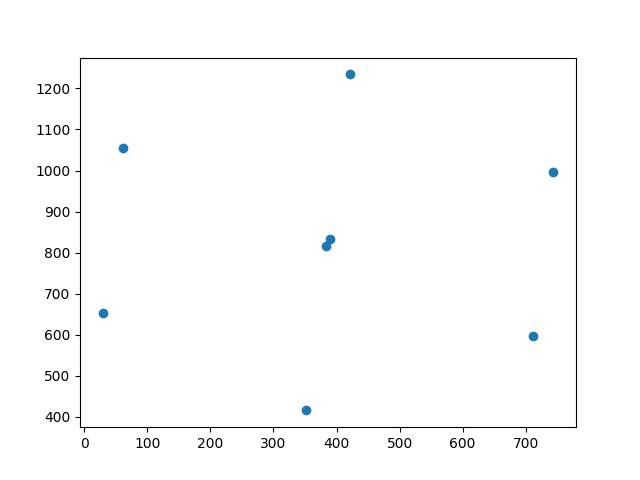

In [96]:
# Convex hull of this is dual subdivision of G
fig, ax = plt.subplots()
ax.plot([352, 29, 384, 61, 712, 389, 744, 421], [416, 654, 816, 1054, 596, 834, 996, 1234], 'o');

<IPython.core.display.Javascript object>


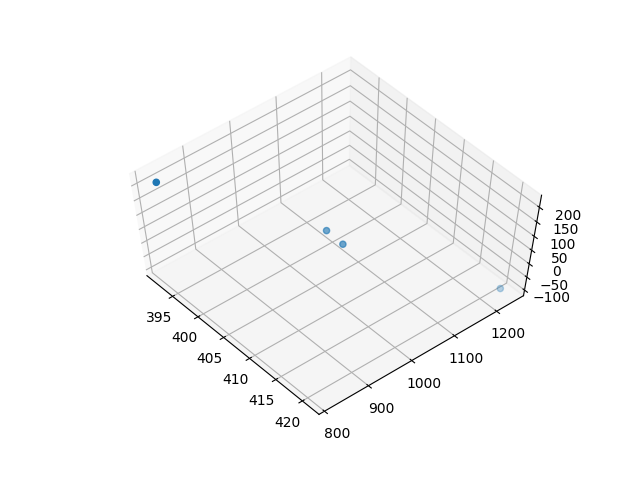

In [97]:
# Convex hull of this, and projection down of upper faces is the dual subdivision of F
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([392, 408, 405, 421], [818, 1026, 1026, 1234], [217, 57, 61, -99]);

Sum absolute error between tropical and rounded neural net: 0.206618279219


<IPython.core.display.Javascript object>


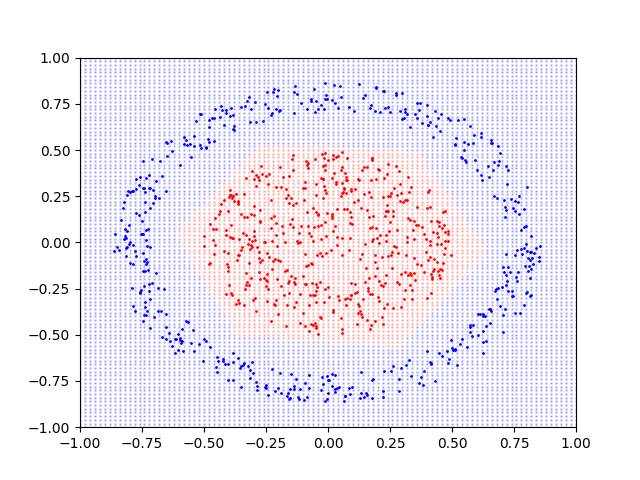

In [86]:
# Plot the tropical representation and compare with the rounded neural network
def tropApply(x1, x2):
    G = np.maximum.reduce([352*x1 + 416*x2, 29*x1 + 654*x2, 384*x1 + 816*x2, 61*x1 + 1054*x2, 712*x1 + 596*x2, 389*x1 + 834*x2, 744*x1 + 996*x2, 421*x1 + 1234*x2])
    H = np.maximum.reduce([217 + 392*x1 + 818*x2, 57 + 408*x1 + 1026*x2, 61 + 405*x1 + 1026*x2, -99 + 421*x1 + 1234*x2])
    
    return H - G

Xtemp = X_test.numpy()
res = tropApply(Xtemp[:, 0], Xtemp[:, 1])

res2 = np.matmul(A1rounded, X_test.numpy().T) + b1rounded[:,np.newaxis]
res2[res2 < 0] = 0
res2 = np.matmul(A2rounded, res2) + b2rounded

print('Sum absolute error between tropical and rounded neural net:', np.sum(np.abs(res-res2)))

fig, ax = plt.subplots()
data_gen2.plotClassifierDataAlt(X_test, res, plot=(fig, ax), alpha=0.2)
X_train, y_train = data_func(1000)
data_gen2.plotClassifierDataAlt(X_train, y_train, plot=(fig, ax))